Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 543613.8125 - val_loss: 307858.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 543578.7500 - val_loss: 307857.3438
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 543563.2500 - val_loss: 307857.4062
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 543552.6875 - val_loss: 307857.2500
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 543535.8750 - val_loss: 307857.0625
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 543534.8125 - val_loss: 307856.9688
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 543533.4375 - val_loss: 307856.8438
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 543532.0000 - val_loss: 307847.3125
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 543524.8750 - val_loss: 307761.2500
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 543478.6875 - val_loss: 307759.7812
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 543

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: in

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 557ms/step - accuracy: 0.4271 - loss: 0.9592 - val_accuracy: 0.8824 - val_loss: 0.6403 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7396 - loss: 0.8798 - val_accuracy: 0.8824 - val_loss: 0.6000 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7292 - loss: 0.8287 - val_accuracy: 0.8824 - val_loss: 0.5632 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7396 - loss: 0.7927 - val_accuracy: 0.8824 - val_loss: 0.5261 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7500 - loss: 0.7433 - val_accuracy: 0.8824 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7500 - loss: 0.7034 - val_accuracy: 0.8824 - val_loss: 0.4641 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7292 - loss: 0.6870 - val_accuracy: 0.8824 - 

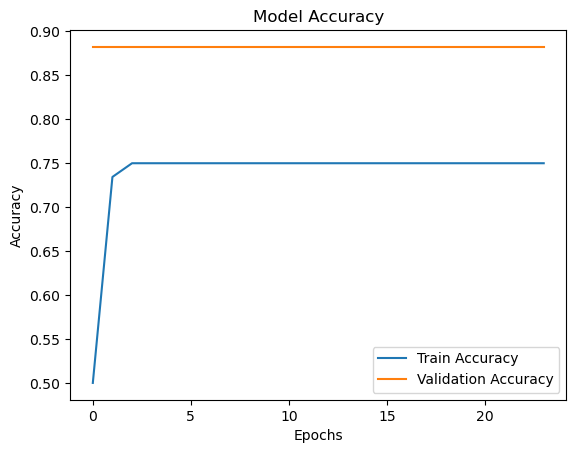

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Step 1: Load the CSV data
data = pd.read_csv("data.csv")  # Replace 'data.csv' with your actual file name

# Step 2: Preprocess the data
feature_columns = [col for col in data.columns if col not in ["Class", "UID", "Trial", "TrialSeq"]]
X = data[feature_columns]  # Exclude non-feature columns
y = data["Class"]

# Encode the target label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Define the Autoencoder structure for feature extraction
input_dim = X.shape[1]  # Number of features in the dataset (31)

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(12, activation='relu')(encoded)  # Bottleneck layer with 12 neurons (compressed features)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)  # Reconstruct input

# Compile and train autoencoder
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Extract encoder part for feature extraction
encoder = Model(input_layer, encoded)

# Transform data using the trained encoder to get the 12 most important features
X_encoded = encoder.predict(X)

# Step 3: Create a DataFrame for the extracted features with the original feature names
# We'll take the top 12 features that are most correlated with the original features.
# First, calculate the correlation between the original features and the encoded features.

correlations = []
for i in range(12):
    corr = np.corrcoef(X_encoded[:, i], X.T)[0, 1:]  # Correlation of encoded feature with each original feature
    correlations.append(corr)

# Convert correlations to a numpy array and transpose for easier selection
correlations = np.array(correlations).T

# Select the top 12 features with the highest correlation (this part is heuristic)
top_features_indices = np.argsort(np.abs(correlations).sum(axis=1))[-12:]

# Step 4: Create a DataFrame for the top 12 selected features
selected_features = X.iloc[:, top_features_indices]  # Select columns based on indices

# Step 5: Add the target variable ('Class') to the selected features DataFrame
selected_features['Class'] = y

# Step 6: Save the selected features to a new CSV file
selected_features.to_csv("extracted_features_auto.csv", index=False)

print("Extracted features saved to 'extracted_features_auto.csv'")

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 5: Standardize the data (for deep learning models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input to match Conv1D's expected input (adding an extra dimension)
X_train = np.expand_dims(X_train, axis=2)  # Reshape to (batch_size, num_features, 1)
X_test = np.expand_dims(X_test, axis=2)    # Reshape to (batch_size, num_features, 1)

# Step 6: Build the Deep Learning Model with CNN for Feature Learning and Dense Layers for Classification

class DeepCNNModel(tf.keras.Model):
    def __init__(self):
        super(DeepCNNModel, self).__init__()
        # CNN layers for feature extraction
        self.conv1 = layers.Conv1D(64, 3, activation='relu', padding='same')
        self.pool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, 3, activation='relu', padding='same')
        self.pool2 = layers.MaxPooling1D(pool_size=2)

        # Fully connected (Dense) layers for classification
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dropout = layers.Dropout(0.3)
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(inputs)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize the model
model = DeepCNNModel()

# Step 7: Compile the model with class weights
class_weights = {0: 1.0, 1: 1.5}  # Adjust class weights if needed for imbalanced classes
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Step 8: Train the model with early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping, lr_scheduler], 
                    class_weight=class_weights)

# Step 9: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Visualize training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



PCA Output Shape: (76, 12), y_filtered Shape: 76
Extracted features saved to extracted_features_gtst.csv with correct feature names and target column.
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7285 - loss: 0.9644 - val_accuracy: 0.7500 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7618 - loss: 0.9421 - val_accuracy: 0.7500 - val_loss: 0.6805 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7722 - loss: 0.9340 - val_accuracy: 0.7500 - val_loss: 0.6753 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.7826 - loss: 0.9244 - val_accuracy: 0.7500 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7618 - loss: 0.9059 - val_accuracy: 0.7500 - val_loss: 0.6643 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7722 - loss: 0.8942 - val_accur

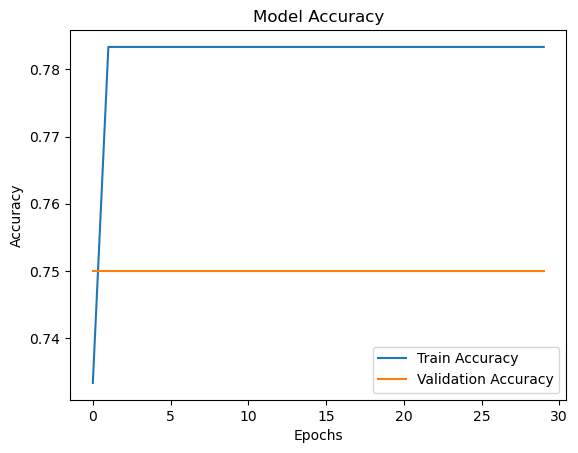

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Step 1: Load the CSV data
data = pd.read_csv("data.csv")  # Replace 'data.csv' with your file name

# Step 2: Preprocess the data
X = data.drop(columns=["Class", "UID", "Trial", "TrialSeq"])  # Exclude non-feature columns
y = data["Class"]

# Handle missing values
X = X.dropna(axis=1)  # Drop columns with NaN values

# Remove constant columns
X = X.loc[:, X.std() > 0]

# Encode the target label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Step 3: Confidence Partitioning - Select high-correlation features with target
confidence_scores = X.corrwith(pd.Series(y)).abs()
confidence_threshold = 0.1  # Set a threshold to keep high-confidence features
high_confidence_features = confidence_scores[confidence_scores > confidence_threshold].index

# If fewer than 12 features are selected, take the top 12
if len(high_confidence_features) < 12:
    high_confidence_features = confidence_scores.nlargest(12).index

X_confidence = X[high_confidence_features]

# Step 4: Sample Filtering - Remove outliers based on Z-scores
z_scores = np.abs(zscore(X_confidence))
mask = (z_scores < 3).all(axis=1)
X_filtered = X_confidence[mask]
y_filtered = y[mask]

# Step 5: PCA - Extract 12 Features while Keeping Original Feature Names
pca = PCA(n_components=12)
X_transformed = pca.fit_transform(X_filtered)

# Use the original feature names
selected_feature_names = list(high_confidence_features[:12])

# Create a DataFrame with extracted features
extracted_features_df = pd.DataFrame(X_transformed, columns=selected_feature_names)

# Add the target column (Class) at the end
extracted_features_df["Class"] = y_filtered  # Fix: No `.values` needed

# Save extracted features to CSV
extracted_features_df.to_csv("extracted_features_gtst.csv", index=False)

print(f"PCA Output Shape: {X_transformed.shape}, y_filtered Shape: {len(y_filtered)}")
print("Extracted features saved to extracted_features_gtst.csv with correct feature names and target column.")

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_filtered, test_size=0.2, random_state=42)

# Step 7: Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input for LSTM (required shape: (samples, time_steps, features))
X_train = np.expand_dims(X_train, axis=1)  # Add time dimension
X_test = np.expand_dims(X_test, axis=1)

# Step 8: Build the BiLSTM Model
class BiLSTMModel(tf.keras.Model):
    def __init__(self):
        super(BiLSTMModel, self).__init__()
        self.lstm1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))
        self.lstm2 = layers.Bidirectional(layers.LSTM(32))
        self.dense1 = layers.Dense(64, activation='relu')
        self.dropout = layers.Dropout(0.3)
        self.dense2 = layers.Dense(32, activation='relu')
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.lstm1(inputs)
        x = self.lstm2(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return self.output_layer(x)

# Initialize model
model = BiLSTMModel()

# Step 9: Compile the model
class_weights = {0: 1.0, 1: 1.5}  # Adjust based on dataset balance
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Step 10: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping, lr_scheduler], 
                    class_weight=class_weights)

# Step 11: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Visualize training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




C:\Users\Lahari\AppData\Local\Temp\ipykernel_7152\1712968510.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features["Class"] = y  # Add target class
C:\Users\Lahari\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Extracted features saved to 'extracted_features_som.csv'
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 898ms/step - accuracy: 0.3750 - loss: 0.6957 - val_accuracy: 0.5882 - val_loss: 0.6920
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5521 - loss: 0.6926 - val_accuracy: 0.7059 - val_loss: 0.6893
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6562 - loss: 0.6895 - val_accuracy: 0.7647 - val_loss: 0.6867
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7292 - loss: 0.6876 - val_accuracy: 0.7647 - val_loss: 0.6843
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7396 - loss: 0.6863 - val_accuracy: 0.8235 - val_loss: 0.6821
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7188 - loss: 0.6845 - val_accuracy: 0.8235 - val_loss: 0.6799
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7188 - loss: 0.6819 - val_accuracy: 0.8824 - val_loss: 0.6777
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0

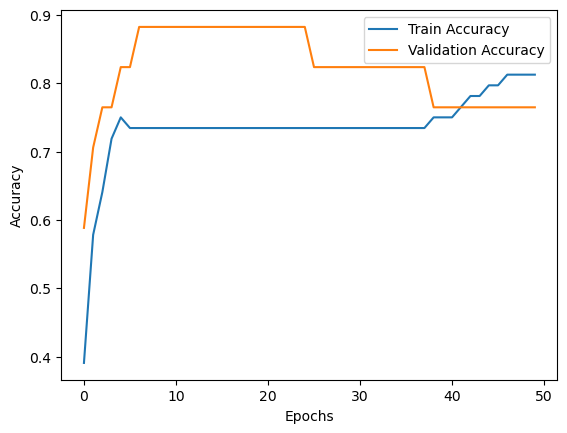

In [11]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from minisom import MiniSom  # Self-Organizing Maps library
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("data.csv")  # Replace with your actual CSV file

# Select feature columns (excluding non-feature identifiers)
feature_columns = [col for col in data.columns if col not in ["Class", "UID", "Trial", "TrialSeq"]]
X = data[feature_columns]
y = data["Class"]

# Encode class labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Define and train SOM
som_grid_size = 4  # SOM grid size (adjustable based on dataset size)
som = MiniSom(som_grid_size, som_grid_size, X_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, 1000)  # Train SOM with 1000 iterations

# Get SOM feature mappings
mapped_features = np.array([som.winner(x) for x in X_scaled])
mapped_features = mapped_features[:, 0] * som_grid_size + mapped_features[:, 1]  # Convert to 1D features

# Reduce to 12 features using clustering (take the first 12 most occurring feature clusters)
top_12_features = np.argsort(np.bincount(mapped_features))[-12:]

# Create DataFrame with selected features
selected_features = X.iloc[:, top_12_features]
selected_features["Class"] = y  # Add target class

# Save extracted features to a new CSV
selected_features.to_csv("extracted_features_som.csv", index=False)
print("Extracted features saved to 'extracted_features_som.csv'")
# Load new extracted feature dataset
df = pd.read_csv("extracted_features_som.csv")

# Split features and target
X_new = df.drop(columns=["Class"]).values
y_new = df["Class"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Standardize the new feature set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM input (batch_size, timesteps, features)
X_train = np.expand_dims(X_train, axis=1)  # Reshape to (batch_size, timesteps=1, features)
X_test = np.expand_dims(X_test, axis=1)
# Define LSTM model
model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[2])),
    layers.LSTM(32),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=32, verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Plot Training Results
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



Extracted features saved to 'extracted_features_pca.csv'
Epoch 1/50


C:\Users\Lahari\AppData\Local\Temp\ipykernel_21784\2453983019.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features["Class"] = y  # Add target class
C:\Users\Lahari\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.4062 - loss: 0.7079 - val_accuracy: 0.3529 - val_loss: 0.7316
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5417 - loss: 0.6942 - val_accuracy: 0.4706 - val_loss: 0.7000
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5521 - loss: 0.6818 - val_accuracy: 0.7059 - val_loss: 0.6732
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6667 - loss: 0.6554 - val_accuracy: 0.8235 - val_loss: 0.6489
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5729 - loss: 0.6548 - val_accuracy: 0.8235 - val_loss: 0.6265
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6771 - loss: 0.6379 - val_accuracy: 0.8235 - val_loss: 0.6062
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7708 - loss: 0.6158 - val_accuracy: 0.8824 - val_loss: 0.5868
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7708 - loss: 0.6117 - val_accuracy: 0.8824 - val_loss: 0.5702
Epoch 9/50

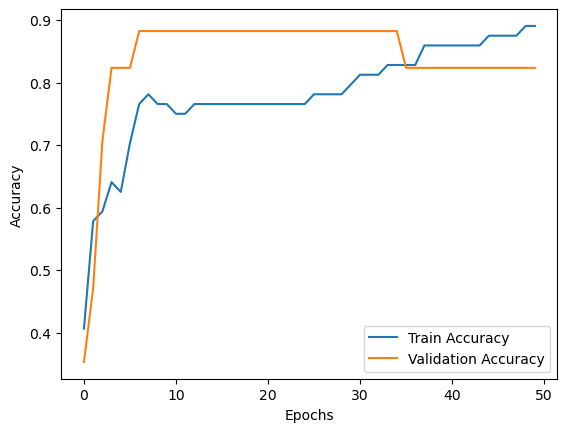

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("data.csv")  # Replace with your actual CSV file

# Select feature columns (excluding non-feature identifiers)
feature_columns = [col for col in data.columns if col not in ["Class", "UID", "Trial", "TrialSeq"]]
X = data[feature_columns]
y = data["Class"]

# Encode class labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensions
pca = PCA(n_components=len(feature_columns))  # Apply PCA on all features initially
X_pca = pca.fit_transform(X_scaled)

# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Get the indices of the top 12 components based on explained variance
top_12_indices = np.argsort(explained_variance_ratio)[::-1][:12]

# Get the loadings (coefficients) for each feature in each principal component
loadings = pca.components_

# Map the most important features to the top 12 components
top_12_features = []
for idx in top_12_indices:
    # Get the feature names with the highest absolute loadings for this component
    sorted_feature_indices = np.argsort(np.abs(loadings[idx]))[::-1]
    top_feature_names = [feature_columns[i] for i in sorted_feature_indices[:1]]  # Select the most influential feature
    top_12_features.extend(top_feature_names)

# Create DataFrame with selected PCA features using original feature names
selected_features = X[top_12_features]  # Select columns based on feature names
selected_features["Class"] = y  # Add target class

# Save extracted features to a new CSV
selected_features.to_csv("extracted_features_pca.csv", index=False)
print("Extracted features saved to 'extracted_features_pca.csv'")

# Load new extracted feature dataset
df = pd.read_csv("extracted_features_pca.csv")

# Split features and target
X_new = df.drop(columns=["Class"]).values
y_new = df["Class"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Standardize the new feature set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define MLP model
model = models.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50, batch_size=32, verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Plot Training Results
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


